# 计算聚类之间的差异并排序

In [ ]:
from __future__ import annotations

import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.set_figure_params(dpi=80, facecolor="white")
sc.logging.print_header()

results_file = "write/pbmc3k.h5ad"

adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)
adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`

sc.pp.filter_cells(adata, min_genes=200)  # this does nothing, in this specific case
sc.pp.filter_genes(adata, min_cells=3)

# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True)

sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

fig, axs = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", show=False, ax=axs[0])
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", show=False, ax=axs[1]);

adata = adata[
    (adata.obs.n_genes_by_counts < 2500) & (adata.obs.n_genes_by_counts > 200) & (adata.obs.pct_counts_mt < 5),
    :,
].copy()
adata.layers["counts"] = adata.X.copy()

sc.pp.normalize_total(adata, target_sum=1e4)

sc.pp.log1p(adata)


sc.pp.highly_variable_genes(
    adata,
    layer="counts",
    n_top_genes=2000,
    min_mean=0.0125,
    max_mean=3,
    min_disp=0.5,
    flavor="seurat_v3",
)

sc.pl.highly_variable_genes(adata)


adata.layers["scaled"] = adata.X.toarray()
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"], layer="scaled")
sc.pp.scale(adata, max_value=10, layer="scaled")

# PCA
sc.pp.pca(adata, layer="scaled", svd_solver="arpack")
sc.pl.pca(adata, annotate_var_explained=True, color="CST3")
sc.pl.pca_variance_ratio(adata, n_pcs=20)
sc.pl.pca_loadings(adata, components=(1, 2), include_lowest=True)

# 计算邻近细胞
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

# Leiden聚类
sc.tl.leiden(
    adata,
    resolution=0.7,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

# PAGA
sc.tl.paga(adata)
# 必须sc.pl.paga，否则umap出错
sc.pl.paga(adata, plot=True)  # remove `plot=False` if you want to see the coarse-grained graph

# UMAP
sc.tl.umap(adata, init_pos='paga')
sc.tl.umap(adata)
sc.pl.umap(adata, color=["leiden", "CD14", "NKG7"])
adata

## sc.tl.rank_genes_groups(method="t-test")

现在对每个细胞亚群中的高差异基因进行排序评估。最简洁高效的方法当属t检验。

比较某一个分组与其他剩余组的差异。有多少组，比多少次。

```
adata.uns['rank_genes_groups'].keys()
dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])
```

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


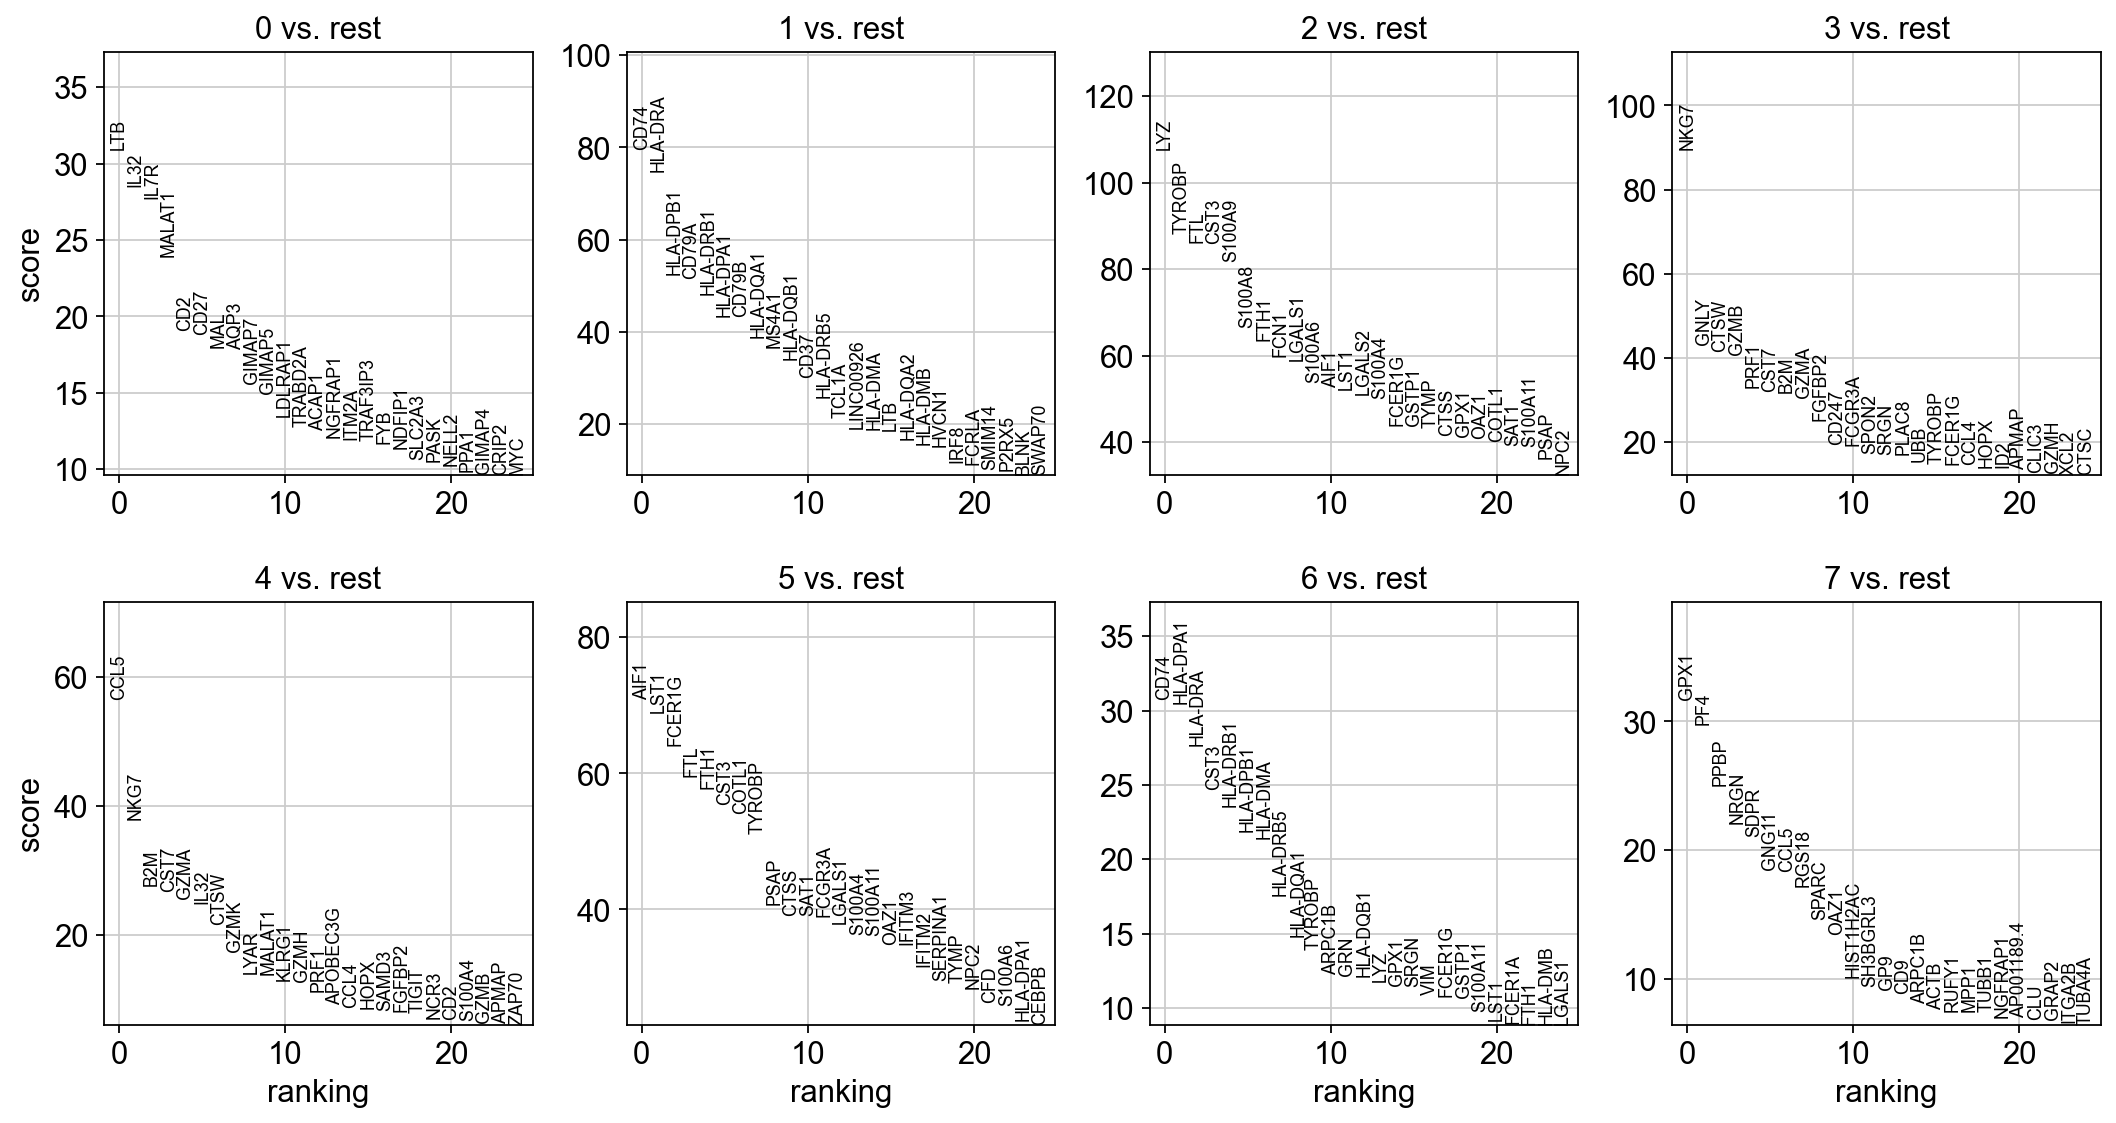

In [14]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

## sc.tl.rank_genes_groups(method="wilcoxon")

威尔科克森秩和检验（曼-惠特尼U检验）的结果与之高度相似。在发表论文时我们建议采用后者，

具体可参考Soneson与Robinson的研究[2018]。若需更高统计功效，还可考虑MAST、limma、

DESeq2等差异分析工具，Python用户则可选用新兴的diffxpy。

ranking genes


    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


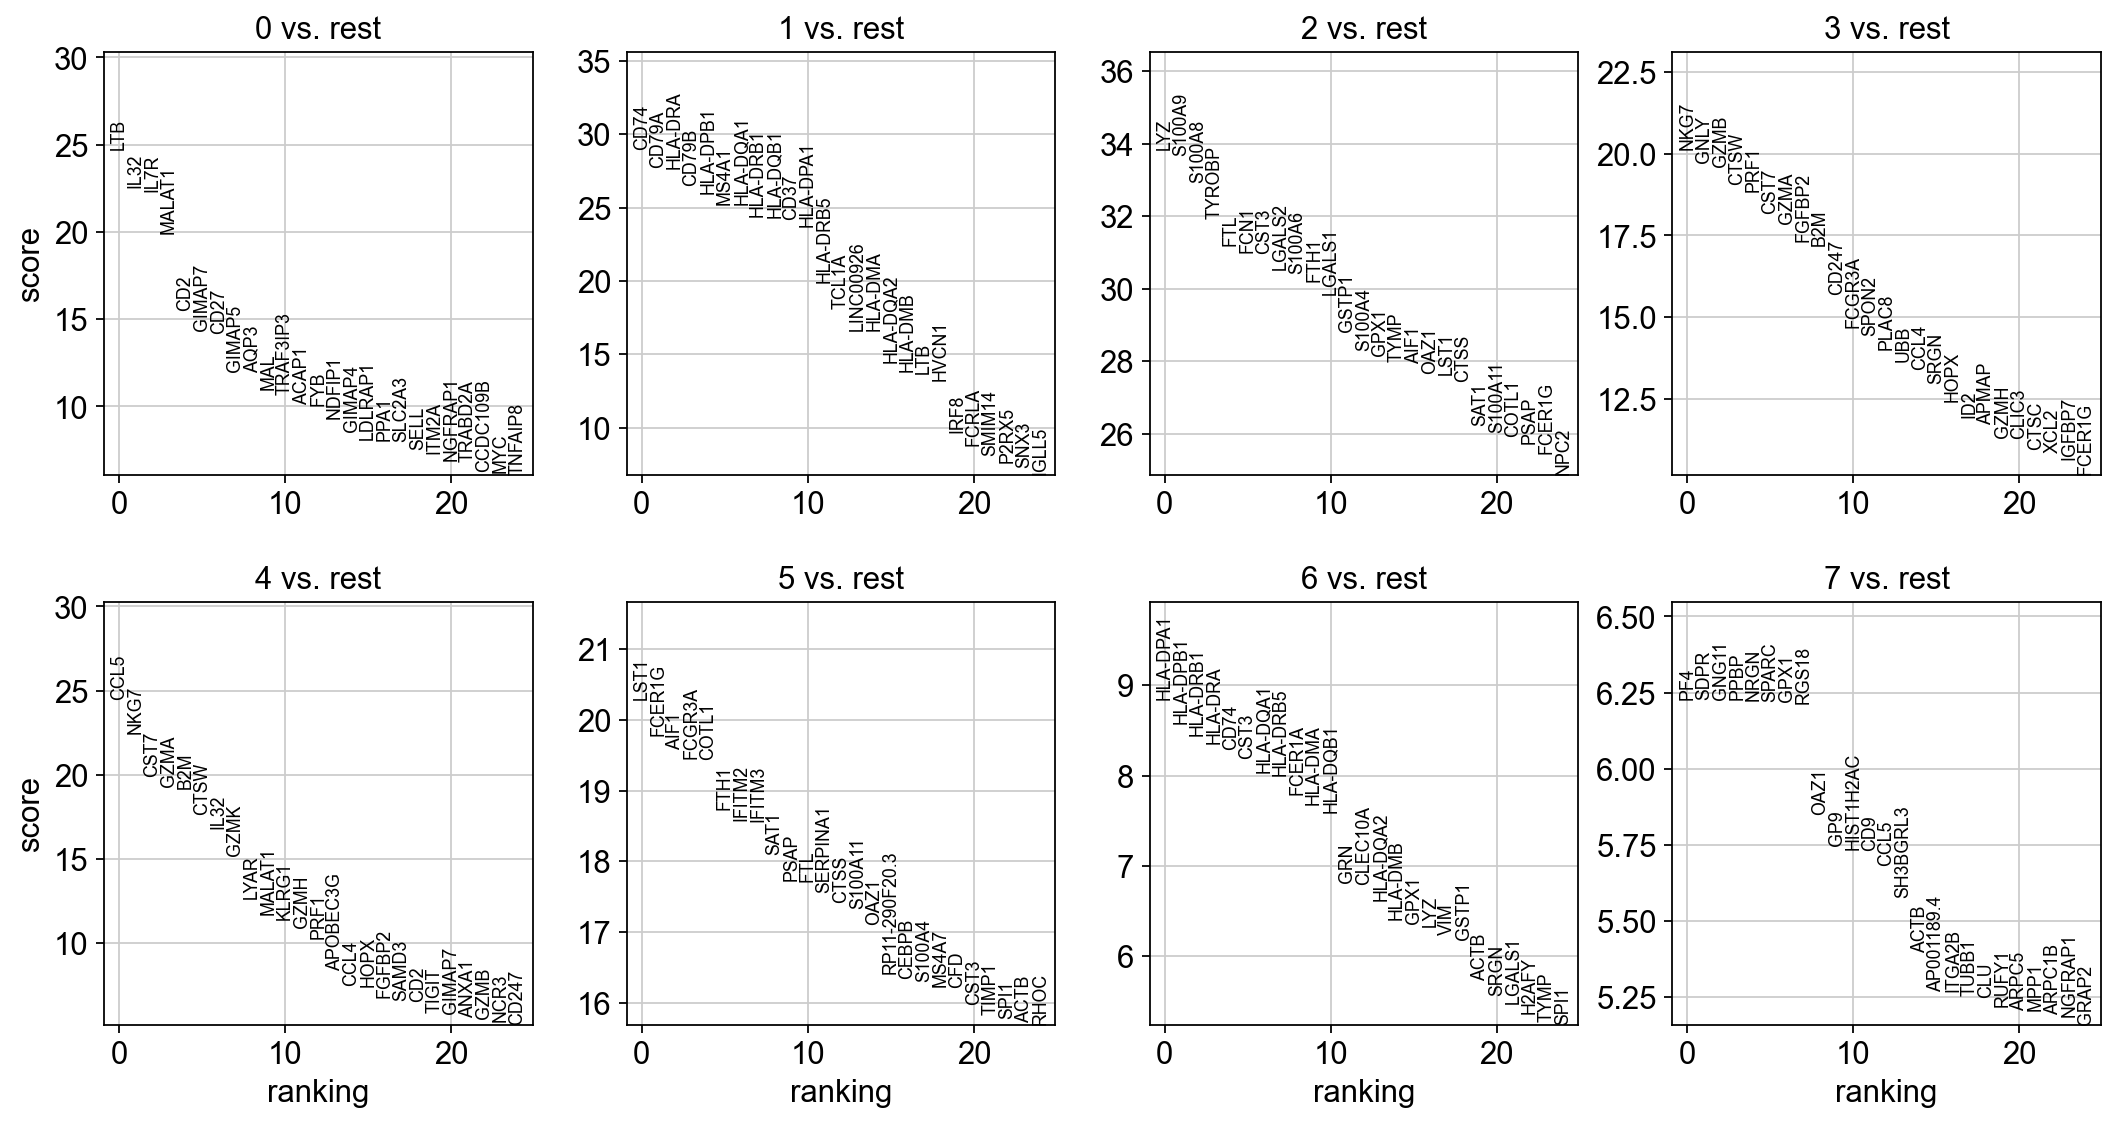

In [16]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
adata.write(results_file)

## sc.tl.rank_genes_groups(method="logreg")


替代方案：采用逻辑回归对基因进行排序。例如Ntranos等人[2019]便曾提出该方法。其核心差异在于——传统差异检验均采用单变量方法，

而本方案使用多变量建模。详见Clark等人[2014]的论述。

这些基因大多属于高表达基因范畴，但存在显著例外——例如CD8A分子（参见下方点阵图）。



ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
 (0:00:03)


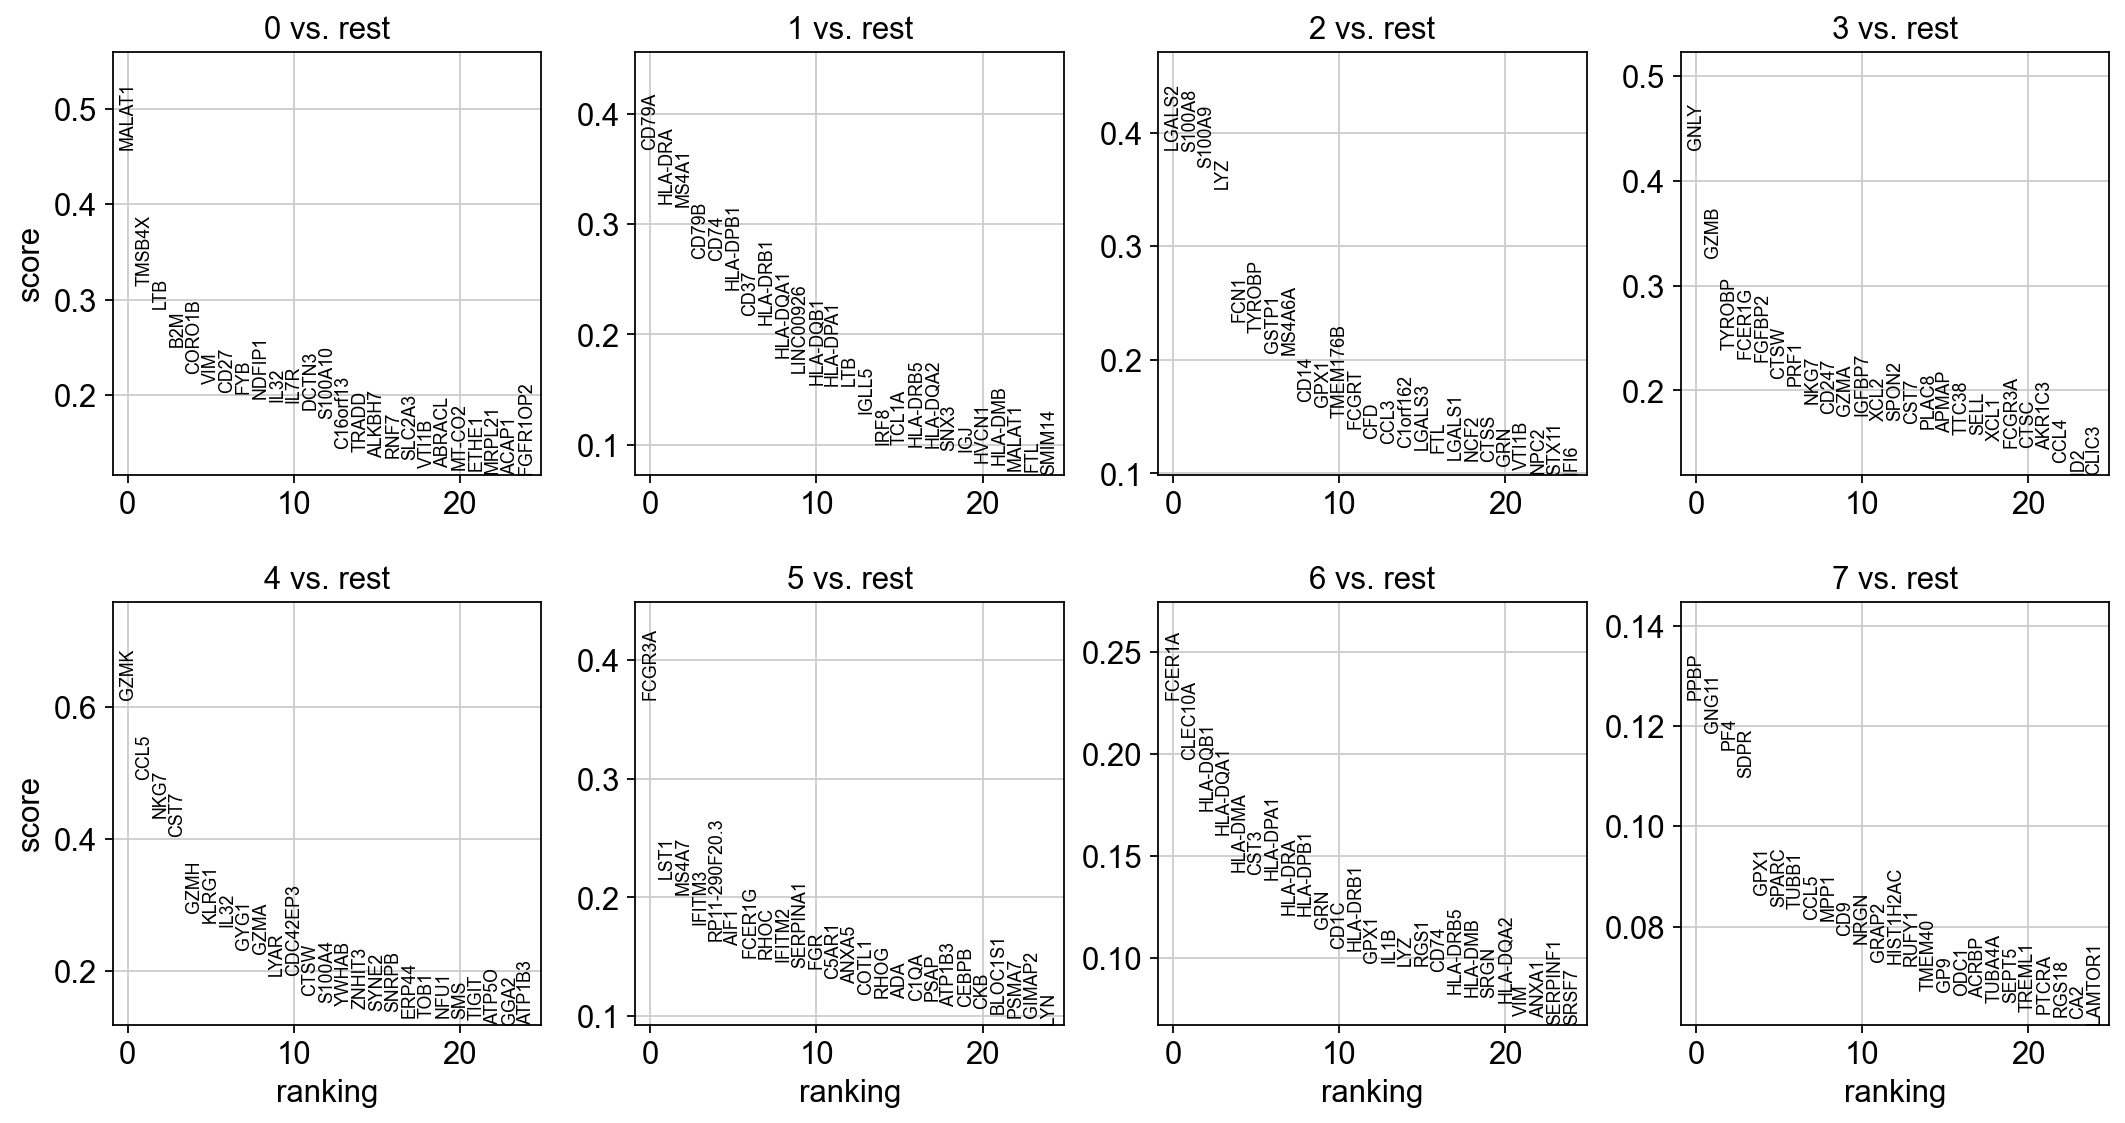

In [17]:
sc.tl.rank_genes_groups(adata, "leiden", mask_var="highly_variable", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [20]:
adata.uns["rank_genes_groups"]["names"]

rec.array([('MALAT1', 'CD79A', 'LGALS2', 'GNLY', 'GZMK', 'FCGR3A', 'FCER1A', 'PPBP'),
           ('TMSB4X', 'HLA-DRA', 'S100A8', 'GZMB', 'CCL5', 'LST1', 'CLEC10A', 'GNG11'),
           ('LTB', 'MS4A1', 'S100A9', 'TYROBP', 'NKG7', 'MS4A7', 'HLA-DQB1', 'PF4'),
           ...,
           ('NKG7', 'S100A6', 'IFITM2', 'HLA-DRB1', 'C16orf13', 'GPX1', 'MALAT1', 'TYROBP'),
           ('CST7', 'SRGN', 'LTB', 'HLA-DPB1', 'SNX3', 'UBB', 'CFD', 'KLF6'),
           ('GZMK', 'S100A4', 'FCGR3A', 'VIM', 'FCER1G', 'LGALS2', 'FTL', 'MALAT1')],
          dtype=[('0', 'O'), ('1', 'O'), ('2', 'O'), ('3', 'O'), ('4', 'O'), ('5', 'O'), ('6', 'O'), ('7', 'O')])

## 差异基因表格

### 查看每组的差异基因

In [26]:
# 读取 wilcox 检验的结果
adata = sc.read(results_file)

pd.DataFrame(adata.uns["rank_genes_groups"]["names"])


,0,1,2,3,4,5,6,7
0,LTB,CD74,LYZ,NKG7,CCL5,LST1,HLA-DPA1,PF4
1,IL32,CD79A,S100A9,GNLY,NKG7,FCER1G,HLA-DPB1,SDPR
2,IL7R,HLA-DRA,S100A8,GZMB,CST7,AIF1,HLA-DRB1,GNG11
3,MALAT1,CD79B,TYROBP,CTSW,GZMA,FCGR3A,HLA-DRA,PPBP
4,CD2,HLA-DPB1,FTL,PRF1,B2M,COTL1,CD74,NRGN
...,...,...,...,...,...,...,...,...
1995,HLA-DPB1,IL32,IL7R,HLA-DRB1,C1orf162,ACAP1,GIMAP7,RBM3
1996,HLA-DPA1,ANXA1,IL32,FTH1,FTL,IL7R,IL32,KLF6
1997,HLA-DRB1,S100A6,B2M,COTL1,CTSS,LTB,LTB,VIM
1998,HLA-DRA,TMSB4X,LTB,LTB,HLA-DRA,IL32,B2M,CD37


### 查看每组的差异基因以及打分

In [27]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame({f"{group}_{key[:1]}": result[key][group] for group in groups for key in ["names", "pvals"]}).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,LTB,4.523933e-135,CD74,1.972305e-184,LYZ,5.016654e-251,NKG7,4.220384e-90,CCL5,1.857211e-132,LST1,1.472603e-91,HLA-DPA1,9.083160e-19,PF4,4.722886e-10
1,IL32,1.391499e-112,CD79A,1.882747e-169,S100A9,1.126831e-248,GNLY,9.274173e-87,NKG7,6.167738e-112,FCER1G,4.577206e-87,HLA-DPB1,1.012875e-17,SDPR,4.733899e-10
2,IL7R,2.756677e-110,HLA-DRA,2.840744e-168,S100A8,6.457752e-238,GZMB,1.164234e-85,CST7,2.245444e-88,AIF1,2.463548e-85,HLA-DRB1,3.140833e-17,GNG11,4.733899e-10
3,MALAT1,4.433395e-88,CD79B,1.868216e-154,TYROBP,1.259221e-223,CTSW,5.115917e-81,GZMA,6.896869e-83,FCGR3A,2.609486e-84,HLA-DRA,6.528837e-17,PPBP,4.744938e-10
4,CD2,4.504927e-54,HLA-DPB1,3.333386e-148,FTL,1.887168e-213,PRF1,3.618719e-79,B2M,3.705110e-82,COTL1,3.772454e-84,CD74,1.090345e-16,NRGN,4.800511e-10


### 比较单个聚类

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


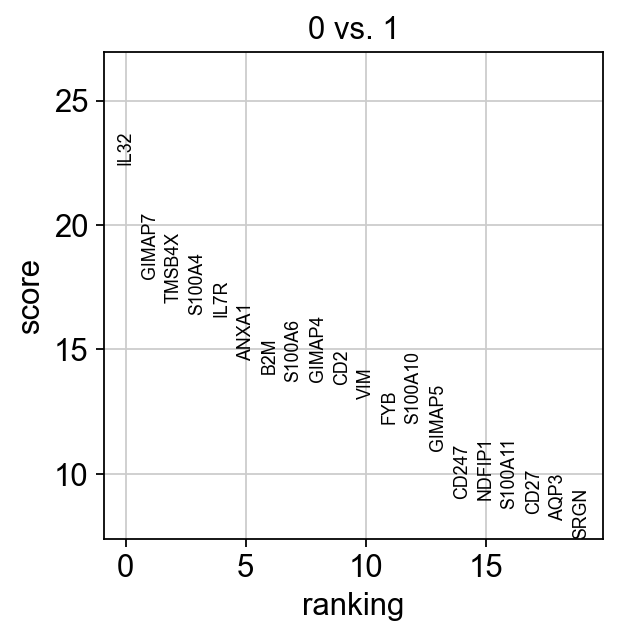

In [29]:
sc.tl.rank_genes_groups(
    adata,
    "leiden",
    mask_var="highly_variable",
    groups=["0"],
    reference="1",
    method="wilcoxon",
)
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

## 查看特定组的细节

/Users/mac/apps/python/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


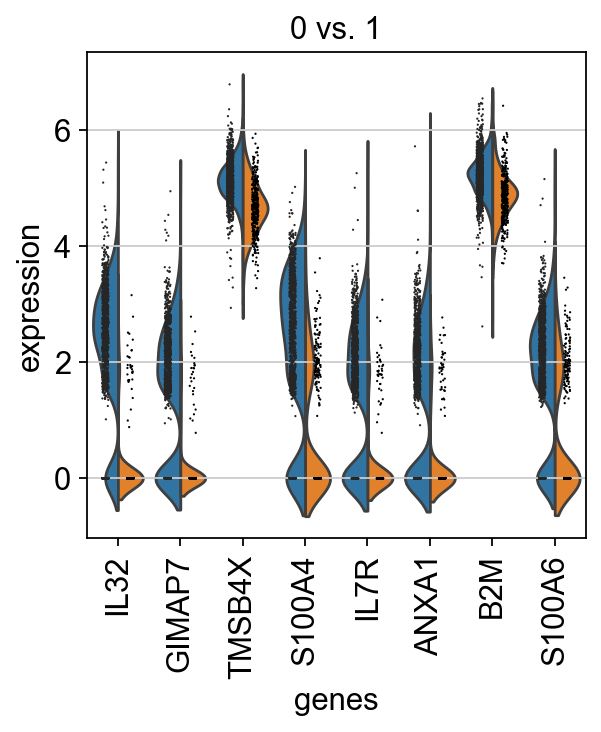

In [30]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

## 查看特定组与其他组的差异

/Users/mac/apps/python/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1328: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


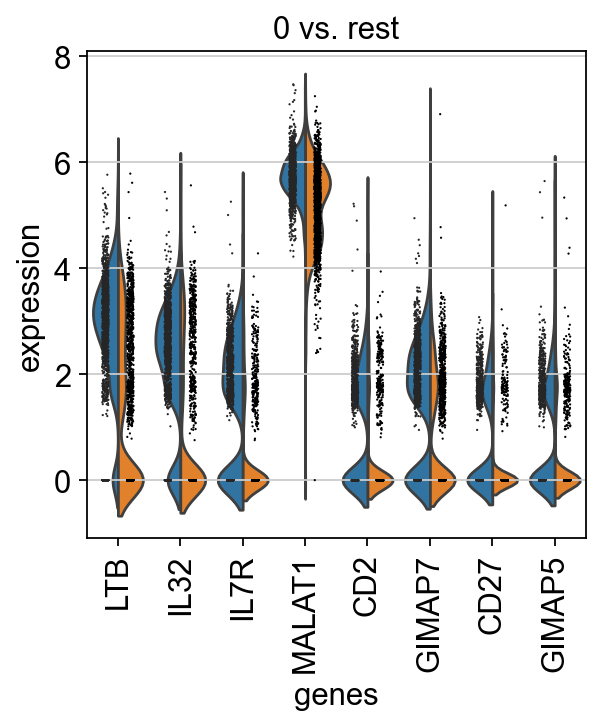

In [31]:
adata = sc.read(results_file)
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

## 在组间比较特定基因

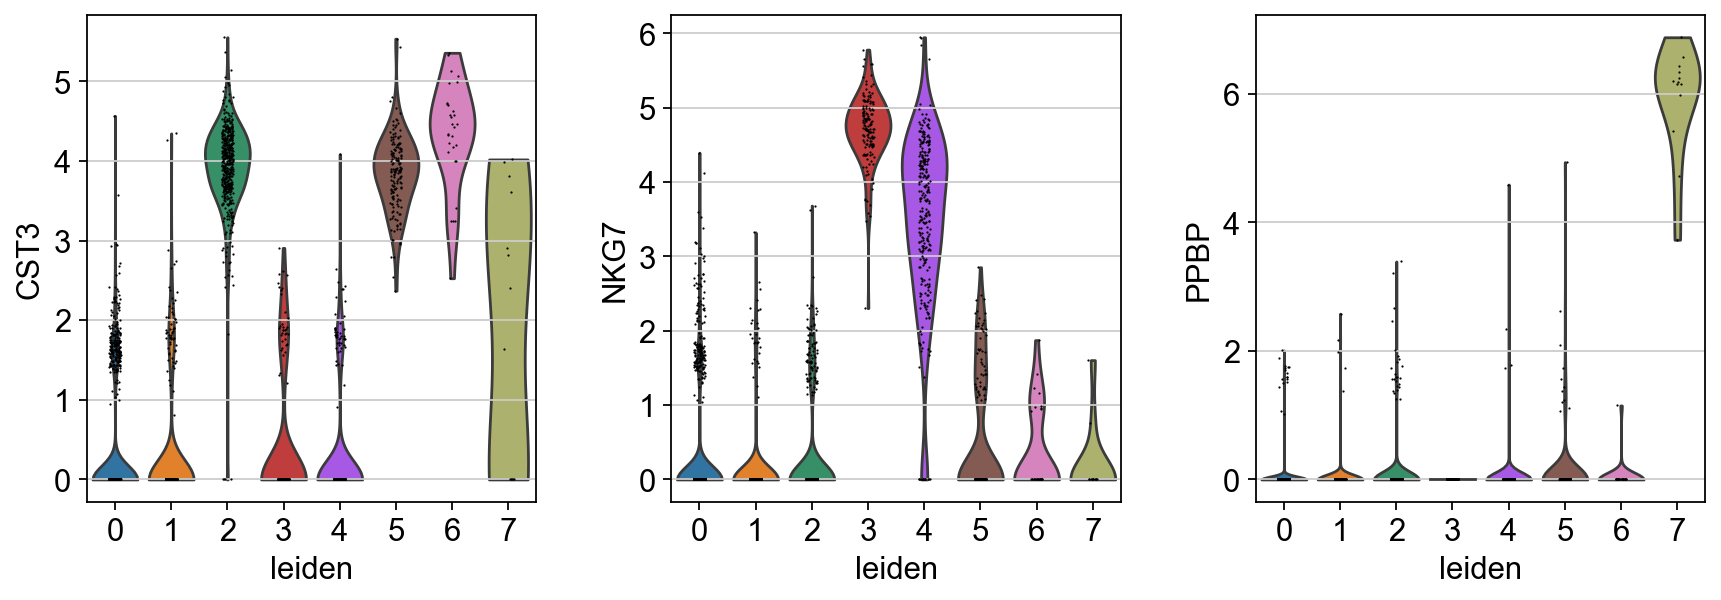

In [32]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

In [28]:
adata.uns['rank_genes_groups']['names'].dtype.names

('0', '1', '2', '3', '4', '5', '6', '7')

# 源码解析

## rand_genes_groups()源码

In [ ]:
def rank_genes_groups(  # noqa: PLR0912, PLR0913, PLR0915
    adata: AnnData,
    groupby: str,
    *,
    mask_var: NDArray[np.bool_] | str | None = None,
    method: _Method | None = None,
):
    """Rank genes for characterizing groups.
    
    """
    # 默认检验方法
    if method is None:
        method = "t-test"

    # 只能是两种校正方法
    avail_corr = {"benjamini-hochberg", "bonferroni"}
    if corr_method not in avail_corr:
        msg = f"Correction method must be one of {avail_corr}."
        raise ValueError(msg)

    # 默认结果保存在 adata.uns['rank_genes_groups'] 字典当中
    # 每次运行，都会覆盖之前的结果，因此可以多次运行
    if key_added is None:
        key_added = "rank_genes_groups"
    adata.uns[key_added] = {}
    adata.uns[key_added]["params"] = dict(
        groupby=groupby,
        reference=reference,
        method=method,
        use_raw=use_raw,
        layer=layer,
        corr_method=corr_method,
    )

    # 检验
    test_obj = _RankGenes(
        adata,
        groups_order,
        groupby,
        mask_var=mask_var,
        reference=reference,
        use_raw=use_raw,
        layer=layer,
        comp_pts=pts,
    )

    # 检验
    test_obj.compute_statistics(
        method,
        corr_method=corr_method,
        n_genes_user=n_genes_user,
        rankby_abs=rankby_abs,
        tie_correct=tie_correct,
        **kwds,
    )
    
    dtypes = {
        "names": "O",
        "scores": "float32",
        "logfoldchanges": "float32",
        "pvals": "float64",
        "pvals_adj": "float64",
    }

    for col in test_obj.stats.columns.levels[0]:
        adata.uns[key_added][col] = test_obj.stats[col].to_records(
            index=False, column_dtypes=dtypes[col]
        )

    logg.info(
        "    finished",
        time=start,
        deep=(
            f"added to `.uns[{key_added!r}]`\n"
            "    'names', sorted np.recarray to be indexed by group ids\n"
            "    'scores', sorted np.recarray to be indexed by group ids\n"
            + (
                "    'logfoldchanges', sorted np.recarray to be indexed by group ids\n"
                "    'pvals', sorted np.recarray to be indexed by group ids\n"
                "    'pvals_adj', sorted np.recarray to be indexed by group ids"
                if method in {"t-test", "t-test_overestim_var", "wilcoxon"}
                else ""
            )
        ),
    )

    """
    adata.uns['rank_genes_groups'].keys()
    dict_keys(['params', 'names', 'scores', 'pvals', 'pvals_adj', 'logfoldchanges'])
    """
    
    return adata if copy else None
